
# The End-to-End Data Science Workflow — Notebook 1/4

**Goal.** Systematically inspect, clean, and visualize a raw loan-default dataset, form initial hypotheses, and produce a minimal, reproducible artifact for modeling.

**This notebook emphasizes best practices:** reproducibility, transparent EDA with narrative + code, careful handling of missingness/outliers/types, and explicit logging of decisions.

**Libraries used (with roles):**
- `numpy`: numerical computing, random seeds.
- `pandas`: data loading/manipulation, type handling, EDA summaries.
- `matplotlib`: deterministic plotting (histograms, boxplots, heatmaps).
- `scipy` (optional): robust stats helpers (commented alternative).
- `pathlib`: safe file paths.


In [1]:

# ====== Configuration & Imports ======
# BEST PRACTICE: Centralize seeds and paths for reproducibility across notebooks.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True)

RAW_DATA_PATH = DATA_DIR / "loan_default_raw.csv"
CLEAN_DATA_PATH = DATA_DIR / "loan_default_clean_base.csv"
EDA_LOG_PATH = ARTIFACTS_DIR / "eda_log.txt"

plt.rcParams["figure.figsize"] = (7, 4.5)  # one-figure-per-plot; deterministic look


In [2]:

# ====== Deterministic Synthetic Data (if raw missing) ======
# BEST PRACTICE: Ensure your teaching/demo pipeline can run end-to-end without external data.
def generate_synthetic_loan_data(n=8000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    states = [f"S{i:02d}" for i in range(1, 11)]
    edu_levels = ["High School", "Bachelor", "Master", "PhD"]
    ownership = ["RENT", "OWN", "MORTGAGE", "OTHER"]
    purposes = ["debt_consolidation", "car", "home_improvement", "small_business", "medical"]
    genders = ["F", "M"]

    start = np.datetime64("2023-01-01")
    application_date = start + rng.integers(0, 730, n).astype("timedelta64[D]")

    age = rng.integers(18, 75, n)
    income = np.clip(rng.lognormal(10.2, 0.55, n), 8_000, 600_000)
    loan_amount = np.clip(rng.lognormal(9.0, 0.65, n), 1_000, 150_000)
    term_months = rng.choice([36, 60], n, p=[0.6, 0.4])
    interest_rate = np.clip(rng.normal(0.11, 0.03, n), 0.03, 0.35)
    credit_score = np.clip(rng.normal(680, 80, n).astype(int), 300, 850)
    employment_years = rng.integers(0, 40, n)
    total_debt = np.clip(rng.lognormal(9.2, 0.7, n), 0, 400_000)

    state = rng.choice(states, n)
    education_level = rng.choice(edu_levels, n, p=[0.35, 0.35, 0.25, 0.05])
    home_ownership = rng.choice(ownership, n, p=[0.45, 0.2, 0.33, 0.02])
    purpose = rng.choice(purposes, n, p=[0.55, 0.1, 0.15, 0.12, 0.08])
    applicant_gender = rng.choice(genders, n, p=[0.47, 0.53])

    # Risk score (logit): plausible dependence
    x_beta = (
        -3.0 + 0.00003*loan_amount + 2.8*interest_rate - 0.000004*income
        - 0.003*(credit_score - 680) - 0.015*employment_years
        + 0.25*(term_months == 60).astype(float)
        + 0.12*(home_ownership == "RENT").astype(float)
        + 0.15*(purpose == "small_business").astype(float)
        + 0.10*(purpose == "medical").astype(float)
    )
    dti = np.clip(total_debt / np.maximum(income, 1.0), 0, 6.0)
    x_beta += 0.6*dti
    p = 1/(1+np.exp(-x_beta))
    default = rng.binomial(1, p, n)

    df = pd.DataFrame({
        "application_id": np.arange(1, n+1),
        "application_date": application_date.astype("datetime64[ns]"),
        "age": age, "income": income, "loan_amount": loan_amount, "term_months": term_months,
        "interest_rate": interest_rate, "credit_score": credit_score, "employment_years": employment_years,
        "total_debt": total_debt, "state": state, "education_level": education_level,
        "home_ownership": home_ownership, "purpose": purpose, "applicant_gender": applicant_gender,
        "default": default
    })
    # Inject missingness and outliers
    rng_mask = rng.random(n)
    df.loc[rng_mask < 0.05, "income"] = np.nan
    df.loc[(rng_mask >= 0.05) & (rng_mask < 0.08), "credit_score"] = np.nan
    df.loc[(rng_mask >= 0.08) & (rng_mask < 0.10), "purpose"] = np.nan
    out_idx = rng.choice(df.index, 12, replace=False)
    df.loc[out_idx, "income"] = df.loc[out_idx, "income"]*10
    df.loc[out_idx, "loan_amount"] = df.loc[out_idx, "loan_amount"]*4
    return df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

if not RAW_DATA_PATH.exists():
    df_raw = generate_synthetic_loan_data()
    df_raw.to_csv(RAW_DATA_PATH, index=False)
    print("Generated synthetic RAW dataset at:", RAW_DATA_PATH)
else:
    print("Found RAW dataset at:", RAW_DATA_PATH)


Found RAW dataset at: data/loan_default_raw.csv


In [3]:

# ====== Load & Initial Audit ======
# BEST PRACTICE: Start with .head(), .info(), and .describe() to orient yourself.
df = pd.read_csv(RAW_DATA_PATH)
display(df.head(5))
print("\n.info():"); print(df.info())
print("\nNumeric summary (.describe):"); display(df.describe().T)
print("\nCategorical preview:")
for c in ["state","education_level","home_ownership","purpose","applicant_gender"]:
    vc = df[c].value_counts(dropna=False).head(10)
    print(f"\nValue counts for {c}:\n{vc}")


,application_id,application_date,age,income,loan_amount,term_months,interest_rate,credit_score,employment_years,total_debt,state,education_level,home_ownership,purpose,applicant_gender,default
0,1783,2023-01-18,66,33787.458397,6513.018145,36,0.140554,625.0,6,6201.768857,S08,High School,MORTGAGE,car,M,0
1,3918,2024-09-12,38,10775.549581,10223.110849,36,0.076815,698.0,10,6662.303728,S05,Master,OWN,debt_consolidation,F,0
2,222,2023-11-29,35,15512.037115,3822.374314,36,0.132256,783.0,14,8143.784048,S08,PhD,MORTGAGE,debt_consolidation,M,0
3,2136,2024-05-15,57,13904.011506,9560.964478,36,0.139436,609.0,13,9755.003469,S02,Bachelor,MORTGAGE,debt_consolidation,F,0
4,5225,2024-01-21,62,19459.656827,13635.613198,60,0.115759,599.0,21,12570.901561,S03,PhD,OWN,debt_consolidation,F,1



.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   application_id    6000 non-null   int64  
 1   application_date  6000 non-null   object 
 2   age               6000 non-null   int64  
 3   income            5691 non-null   float64
 4   loan_amount       6000 non-null   float64
 5   term_months       6000 non-null   int64  
 6   interest_rate     6000 non-null   float64
 7   credit_score      5835 non-null   float64
 8   employment_years  6000 non-null   int64  
 9   total_debt        6000 non-null   float64
 10  state             6000 non-null   object 
 11  education_level   6000 non-null   object 
 12  home_ownership    6000 non-null   object 
 13  purpose           5878 non-null   object 
 14  applicant_gender  6000 non-null   object 
 15  default           6000 non-null   int64  
dtypes: float64(5), int64(5), object(

,count,mean,std,min,25%,50%,75%,max
application_id,6000.0,3000.500000,1732.195139,1.000000,1500.750000,3000.500000,4500.250000,6000.000000
age,6000.0,45.773000,16.286048,18.000000,32.000000,46.000000,60.000000,74.000000
income,5691.0,30762.394053,19277.747295,8000.000000,19226.571710,26432.054120,37584.785836,384981.899103
loan_amount,6000.0,9883.951683,6812.887770,1000.000000,5483.359687,8107.067326,12205.389834,109601.337157
term_months,6000.0,45.732000,11.784707,36.000000,36.000000,36.000000,60.000000,60.000000
interest_rate,6000.0,0.110571,0.030234,0.030000,0.090024,0.110822,0.130768,0.220475
credit_score,5835.0,679.138132,78.732112,339.000000,625.000000,679.000000,734.000000,850.000000
employment_years,6000.0,19.668333,11.539881,0.000000,10.000000,20.000000,30.000000,39.000000
total_debt,6000.0,12423.764224,10100.554133,696.048644,6180.736601,9755.531975,15601.100825,300000.000000
default,6000.0,0.103167,0.304202,0.000000,0.000000,0.000000,0.000000,1.000000



Categorical preview:

Value counts for state:
state
S03    638
S01    623
S04    617
S06    616
S10    610
S08    600
S07    590
S09    582
S05    565
S02    559
Name: count, dtype: int64

Value counts for education_level:
education_level
Bachelor       2115
High School    2103
Master         1509
PhD             273
Name: count, dtype: int64

Value counts for home_ownership:
home_ownership
RENT        2708
MORTGAGE    2002
OWN         1164
OTHER        126
Name: count, dtype: int64

Value counts for purpose:
purpose
debt_consolidation    3206
home_improvement       892
small_business         703
car                    599
medical                478
NaN                    122
Name: count, dtype: int64

Value counts for applicant_gender:
applicant_gender
M    3182
F    2818
Name: count, dtype: int64


In [4]:

# ====== Enforce Types Early ======
# BEST PRACTICE: Correct types avoids silent bugs, speeds operations, and makes EDA truthful.
df["application_date"] = pd.to_datetime(df["application_date"], errors="coerce")
for c in ["state","education_level","home_ownership","purpose","applicant_gender"]:
    df[c] = df[c].astype("category")
print(df.dtypes.head(15))


application_id               int64
application_date    datetime64[ns]
age                          int64
income                     float64
loan_amount                float64
term_months                  int64
interest_rate              float64
credit_score               float64
employment_years             int64
total_debt                 float64
state                     category
education_level           category
home_ownership            category
purpose                   category
applicant_gender          category
dtype: object


income              0.051500
credit_score        0.027500
purpose             0.020333
application_id      0.000000
application_date    0.000000
age                 0.000000
loan_amount         0.000000
term_months         0.000000
interest_rate       0.000000
employment_years    0.000000
total_debt          0.000000
state               0.000000
education_level     0.000000
home_ownership      0.000000
applicant_gender    0.000000
dtype: float64

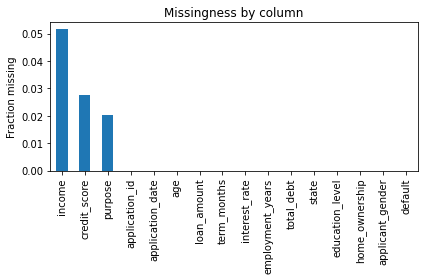

Rows with any missing values: 0.096


In [5]:

# ====== Missingness Profile ======
missing_pct = df.isna().mean().sort_values(ascending=False)
display(missing_pct.head(15))

fig = plt.figure()
missing_pct.plot(kind="bar")
plt.ylabel("Fraction missing")
plt.title("Missingness by column")
plt.tight_layout(); plt.show()

# BEST PRACTICE: Quantify rows with any missingness (can guide imputation strategies).
rows_with_any_na = df.isna().any(axis=1).mean()
print(f"Rows with any missing values: {rows_with_any_na:.3f}")


In [6]:

# ====== Duplicate & Integrity Checks ======
# BEST PRACTICE: Duplicates and impossible values corrupt downstream learning.
dups = df.duplicated(subset=["application_id"]).sum()
print("Duplicate application_id rows:", dups)

# Sanity checks (define as assertions in production)
assert df["age"].min() >= 0, "Negative ages detected"
assert df["interest_rate"].between(0,1).mean() > 0.99, "Interest rate likely not in [0,1]"


Duplicate application_id rows: 0


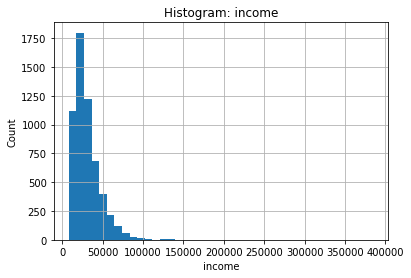

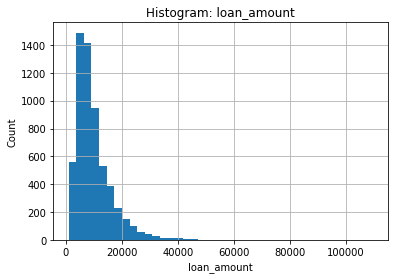

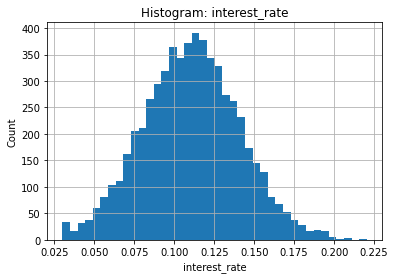

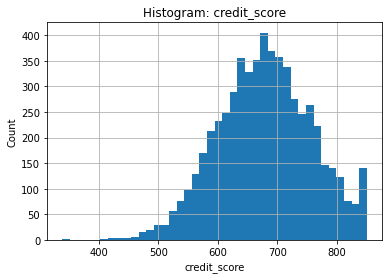

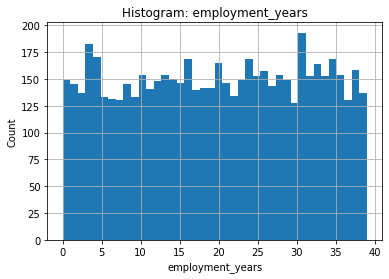

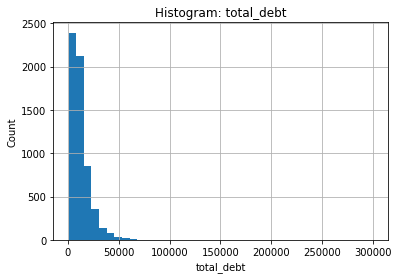

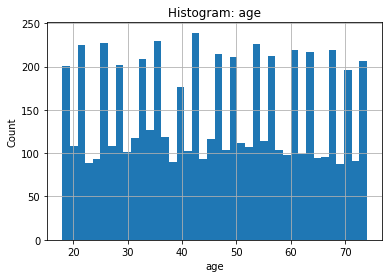

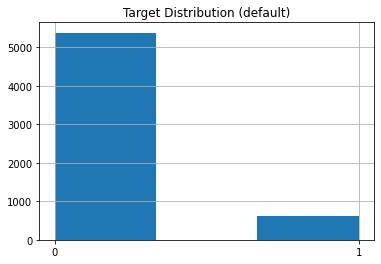

In [7]:

# ====== Univariate Distributions (focused) ======
num_cols = ["income","loan_amount","interest_rate","credit_score","employment_years","total_debt","age"]
for col in num_cols:
    fig = plt.figure()
    plt.hist(df[col].dropna(), bins=40)
    plt.xlabel(col); plt.ylabel("Count"); plt.title(f"Histogram: {col}")
    plt.grid(True); plt.show()

fig = plt.figure()
plt.hist(df["default"], bins=3); plt.xticks([0,1]); plt.title("Target Distribution (default)")
plt.grid(True); plt.show()


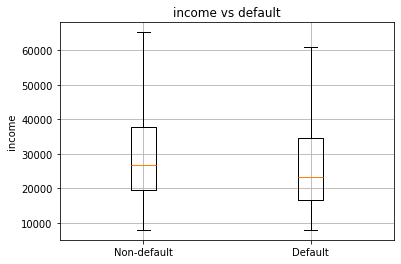

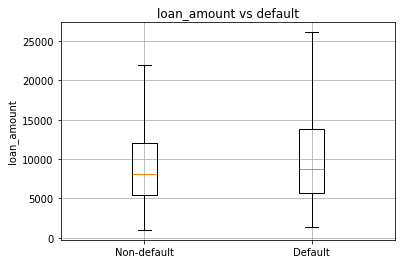

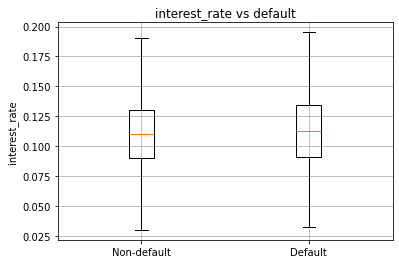

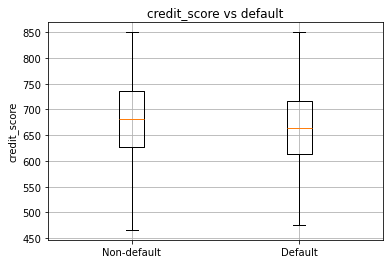


Default rate by education_level (top 10):
education_level
High School    0.110319
PhD            0.109890
Bachelor       0.099764
Master         0.096753
Name: default, dtype: float64

Default rate by home_ownership (top 10):
home_ownership
MORTGAGE    0.107892
RENT        0.102290
OWN         0.098797
OTHER       0.087302
Name: default, dtype: float64

Default rate by purpose (top 10):
purpose
medical               0.123431
car                   0.116861
small_business        0.115220
home_improvement      0.104260
debt_consolidation    0.095446
Name: default, dtype: float64

Default rate by state (top 10):
state
S06    0.125000
S03    0.119122
S01    0.117175
S02    0.105546
S10    0.103279
S05    0.100885
S04    0.092382
S09    0.091065
S08    0.090000
S07    0.084746
Name: default, dtype: float64


/tmp/ipykernel_35374/2620417805.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df.groupby(c)["default"].mean().sort_values(ascending=False).head(10)


In [8]:

# ====== Bivariate Views: Default vs Key Drivers ======
for col in ["income","loan_amount","interest_rate","credit_score"]:
    fig = plt.figure()
    data0 = df.loc[df["default"]==0, col].dropna()
    data1 = df.loc[df["default"]==1, col].dropna()
    plt.boxplot([data0, data1], labels=["Non-default","Default"], showfliers=False)
    plt.ylabel(col); plt.title(f"{col} vs default"); plt.grid(True); plt.show()

# Category vs default: quick rate table
for c in ["education_level","home_ownership","purpose","state"]:
    tab = df.groupby(c)["default"].mean().sort_values(ascending=False).head(10)
    print(f"\nDefault rate by {c} (top 10):\n{tab}")


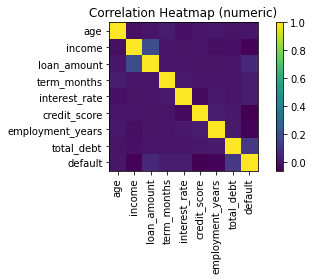

In [9]:

# ====== Correlation Heatmap (numerics only) ======
num = df.select_dtypes(include=["number"]).drop(columns=["application_id"], errors="ignore")
corr = num.corr(numeric_only=True)
fig = plt.figure()
plt.imshow(corr, interpolation="none")
plt.colorbar()
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[0]), corr.index)
plt.title("Correlation Heatmap (numeric)")
plt.tight_layout(); plt.show()

# CAUTION: Correlation ≠ causation. Use to flag multicollinearity candidates.


In [10]:

# ====== Outlier Screening (NaN-safe z-scores) ======
# BEST PRACTICE: Quantify; do not drop indiscriminately. Consider transformations or robust models.
mean = num.mean(); std = num.std(ddof=1).replace(0, np.nan)
z = (num - mean)/std
outlier_counts = (np.abs(z) > 4).sum(axis=0).astype(int)
print("Approximate |z|>4 counts:\n", outlier_counts.sort_values(ascending=False).head(12))


Approximate |z|>4 counts:
 loan_amount         43
total_debt          34
income              27
credit_score         1
age                  0
term_months          0
interest_rate        0
employment_years     0
default              0
dtype: int64


In [11]:

# ====== Target Leakage Brainstorm ======
# BEST PRACTICE: Identify variables that *should not* be used (post-outcome info).
leakage_candidates = ["application_id"]  # IDs or fields not causally prior to default
print("Leakage candidates:", leakage_candidates)


Leakage candidates: ['application_id']


In [12]:

# ====== Minimal Cleaning Artifact & EDA Log ======
df.to_csv(CLEAN_DATA_PATH, index=False)

with open(EDA_LOG_PATH, "w", encoding="utf-8") as f:
    f.write("EDA LOG (Notebook 1 Expanded)\n")
    f.write("- Types enforced (date, categories)\n")
    f.write("- Missingness profiled; no imputation yet (pipelines handle it)\n")
    f.write("- Outliers screened via z-scores; no removal here\n")
    f.write(f"- Saved base CSV to: {CLEAN_DATA_PATH}\n")

print("Saved cleaned base dataset to:", CLEAN_DATA_PATH)


Saved cleaned base dataset to: data/loan_default_clean_base.csv
